In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, Embedding, concatenate, Reshape
from tensorflow.keras import Model

In [2]:
df = pd.read_csv('..\\data\\processed2\\processed_data.csv', index_col=0)

In [3]:
inds = df.index[df['inning']<9]

In [4]:
df['event_final'] = df['event_final'].astype('category')
inning = df['inning'].values
df['inning_diff'] = np.maximum(0, np.minimum(1, inning[1:] - inning[:-1])).astype(int).tolist() + [0]
df['inning_diff'] = df['inning_diff'].astype('category')
home_score = df['home_score'].values
visiting_score = df['visiting_score'].values
df['home_score_diff'] = np.maximum(0,np.minimum(4,home_score[1:] - home_score[:-1])).astype(int).tolist() + [0]
df['home_score_diff'] = df['home_score_diff'].astype('category')
df['visiting_score'] = df['visiting_score'].astype('category')
df['visiting_score_diff'] = np.maximum(0,np.minimum(4,visiting_score[1:]-visiting_score[:-1])).astype(int).tolist()+[0]
df['visiting_score_diff'] = df['visiting_score_diff'].astype('category')
df['outs'] = df['outs'].astype('category')

In [5]:
df['event_final_code'] = df['event_final'].cat.codes
df['home_score_code'] = df['home_score_diff'].cat.codes
df['visiting_score_code'] = df['visiting_score_diff'].cat.codes
df['outs_code'] = df['outs'].cat.codes

In [6]:
first = [0]*len(df)
second = [0]*len(df)
third = [0]*len(df)
for i in df.index:
    if isinstance(df.loc[i, '1st runner'], str):
        first[i] = 1
    if isinstance(df.loc[i, '2nd runner'], str):
        second[i] = 1
    if isinstance(df.loc[i, '3rd runner'], str):
        third[i] = 1
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [7]:
first = np.array(first)
second = np.array(second)
third = np.array(third)

In [8]:
df['first'] = first
df['second'] = second
df['third'] = third

In [9]:
situation = df[['inning', 'home_score', 'visiting_score', 'batting team', 'outs', 'first', 'second', 'third']].values
batter = df['res batter'].values
pitcher = df['res pitcher'].values
balls = df['balls'].values
strikes = df['strikes'].values
fouls = df['fouls'].values
outcome = df['event_final_code'].values
outcome_onehot = pd.get_dummies(df['event_final_code']).values
inning_diff = df['inning_diff'].values#pd.get_dummies(df['inning_code']).values
home_score_onehot = pd.get_dummies(df['home_score_code']).values
visiting_score_onehot = pd.get_dummies(df['visiting_score_code']).values
outs_onehot = pd.get_dummies(df['outs_code']).values

In [10]:
samples = inds.shape[0]-1

p = np.random.permutation(samples)
train_inds = inds[p[:samples//5 * 4]]
test_inds = inds[p[samples//5 * 4:]]

In [11]:
situation_train = situation[train_inds, 3:]
# outcome_train = outcome_onehot[train_inds]
outcome_train = df['event_final_code'].values[train_inds]
y_train = [inning_diff[train_inds].astype(float), 
           df['batting team'].values[train_inds+1].astype(float), 
           outs_onehot[train_inds+1].astype(float), 
           visiting_score_onehot[train_inds].astype(float), 
           home_score_onehot[train_inds].astype(float),
           first[train_inds+1].astype(float),
           second[train_inds+1].astype(float),
           third[train_inds+1].astype(float)]

situation_test = situation[test_inds, 3:]
# outcome_test = outcome_onehot[test_inds]
outcome_test = df['event_final_code'].values[test_inds]
y_test = [inning_diff[test_inds].astype(float), 
          df['batting team'].values[test_inds+1].astype(float), 
          outs_onehot[test_inds+1].astype(float), 
          visiting_score_onehot[test_inds].astype(float), 
          home_score_onehot[test_inds].astype(float),
          first[test_inds+1].astype(float),
          second[test_inds+1].astype(float),
          third[test_inds+1].astype(float)]

In [12]:
X_train = [situation_train.astype(float), np.expand_dims(outcome_train, axis=1).astype(np.int32)]
X_test = [situation_test.astype(float), np.expand_dims(outcome_test, axis=1).astype(np.int32)]

In [17]:
def build_model(sit_shape_in, outcome_size, hidden, activations):
    
    situation = Input(shape=(sit_shape_in,))

    outcome = Input(shape=(1,))

    out_emb = Embedding(outcome_size, 8)(outcome)
    
    out_emb = Reshape((8,))(out_emb)

    X = concatenate([situation, out_emb], axis=-1)
    
    X_int = Dense(hidden, activation=activations)(X)

    X_int = Dense(hidden, activation=activations)(X_int)
    
    X_int = Dense(hidden, activation=activations)(X_int)

    inning_diff = Dense(1, activation='sigmoid')(X_int)

    half_inning = Dense(1, activation='sigmoid')(X_int)

    outs = Dense(3, activation='softmax')(X_int)

    visiting_score = Dense(5, activation='softmax')(X_int)

    home_score = Dense(5, activation='softmax')(X_int)

    first = Dense(1, activation='sigmoid')(X_int)

    second = Dense(1, activation='sigmoid')(X_int)

    third = Dense(1, activation='sigmoid')(X_int)

    return Model(inputs=[situation, outcome], 
                 outputs=[inning_diff, half_inning, outs, visiting_score, home_score, first, second, third])

In [18]:
model = build_model(situation_train.shape[1], np.max(outcome_train)+1, 64, 'relu')

In [19]:
def compile_model(model, LR):
    adam = tf.keras.optimizers.Adam(lr=LR)
    model.compile(
        optimizer=adam,
        loss=['binary_crossentropy', 'binary_crossentropy', 'categorical_crossentropy',
            'categorical_crossentropy', 'categorical_crossentropy', 'binary_crossentropy',
            'binary_crossentropy', 'binary_crossentropy'],
        metrics=['accuracy'])
    return model

In [23]:
model = compile_model(model, 1e-4)
for i in range(200):
    if i == 100:
        model = compile_model(model, 1e-3)
    print('epoch: '+str(i+1))
    model.fit(x=X_train,
              y=y_train, 
              batch_size=situation_train.shape[0]//20,
              epochs=1,
              verbose=0)

epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22


KeyboardInterrupt: 

In [24]:
[loss, l1, l2, l3, l4, l5, l6, l7, l8, 
 inning_acc, half_inning_acc, outs_acc, 
 visiting_score_acc, home_score_acc, 
 first_acc, second_acc, third_acc] = model.evaluate(X_test, y_test, batch_size=situation_test.shape[0]//20)

162388/162388 [==============================] - 1s 6us/sample - loss: 0.7018 - dense_13_loss: 0.0256 - dense_14_loss: 0.0512 - dense_15_loss: 0.1207 - dense_16_loss: 0.0265 - dense_17_loss: 0.0292 - dense_18_loss: 0.1622 - dense_19_loss: 0.1576 - dense_20_loss: 0.1085 - dense_13_accuracy: 0.9906 - dense_14_accuracy: 0.9813 - dense_15_accuracy: 0.9611 - dense_16_accuracy: 0.9888 - dense_17_accuracy: 0.9878 - dense_18_accuracy: 0.9443 - dense_19_accuracy: 0.9397 - dense_20_accuracy: 0.9525


In [25]:
print('inning accuracy: '+str(inning_acc))
print('half inning accuracy: '+str(half_inning_acc))
print('outs accuracy: '+str(outs_acc))
print('visiting score accuracy: '+str(visiting_score_acc))
print('home score accuracy: '+str(home_score_acc))
print('first accuracy: '+str(first_acc))
print('second accuracy: '+str(second_acc))
print('third accuracy: '+str(third_acc))

inning accuracy: 0.9905966
half inning accuracy: 0.98125476
outs accuracy: 0.9611363
visiting score accuracy: 0.9888046
home score accuracy: 0.98775774
first accuracy: 0.94434315
second accuracy: 0.9396692
third accuracy: 0.9525273


In [22]:
print('inning accuracy: '+str(inning_acc))
print('half inning accuracy: '+str(half_inning_acc))
print('outs accuracy: '+str(outs_acc))
print('visiting score accuracy: '+str(visiting_score_acc))
print('home score accuracy: '+str(home_score_acc))
print('first accuracy: '+str(first_acc))
print('second accuracy: '+str(second_acc))
print('third accuracy: '+str(third_acc))

inning accuracy: 0.99054736
half inning accuracy: 0.98106384
outs accuracy: 0.96068674
visiting score accuracy: 0.98826885
home score accuracy: 0.98738825
first accuracy: 0.94427544
second accuracy: 0.9390226
third accuracy: 0.95163435


In [26]:
y_pred = model(X_test)

In [27]:
y_pred = np.concatenate((y_pred), axis=1)

In [28]:
model.save('..\\models\\situation_prediction_relu4')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ..\models\situation_prediction_relu4\assets
INFO:tensorflow:Assets written to: ..\models\situation_prediction_relu4\assets


In [29]:
model2 = tf.keras.models.load_model('..\\models\\situation_prediction_relu4')

In [30]:
cats = df['event_final'].astype('category')

outcome_dict = {}
for i, cat in enumerate(cats.cat.categories):
    outcome_dict[cat] = i
outcome_dict_rev = dict(enumerate(cats.cat.categories))
N_outcomes = len(outcome_dict)

In [31]:
outcome_dict

{'1B': 0,
 '1G': 1,
 '1L': 2,
 '1SH': 3,
 '2B': 4,
 '2G': 5,
 '2P': 6,
 '2SH': 7,
 '34G': 8,
 '3B': 9,
 '3G': 10,
 '3L': 11,
 '3P': 12,
 '3SH': 13,
 '4G': 14,
 '4L': 15,
 '4P': 16,
 '5B': 17,
 '5G': 18,
 '5L': 19,
 '5P': 20,
 '5SH': 21,
 '6G': 22,
 '6L': 23,
 '6P': 24,
 '7F': 25,
 '7L': 26,
 '7SF': 27,
 '8F': 28,
 '8L': 29,
 '8SF': 30,
 '9F': 31,
 '9L': 32,
 '9SF': 33,
 'C': 34,
 'D4G': 35,
 'D5G': 36,
 'D7F': 37,
 'D7G': 38,
 'D7L': 39,
 'D8F': 40,
 'D8G': 41,
 'D8L': 42,
 'D9F': 43,
 'D9G': 44,
 'D9L': 45,
 'DG7': 46,
 'DG8': 47,
 'DG9': 48,
 'FC1': 49,
 'FC2': 50,
 'FC3': 51,
 'FC4': 52,
 'FC5': 53,
 'FC6': 54,
 'H': 55,
 'H7': 56,
 'H78': 57,
 'H8': 58,
 'H89': 59,
 'H9': 60,
 'IW': 61,
 'K': 62,
 'S1B': 63,
 'S1G': 64,
 'S1L': 65,
 'S2B': 66,
 'S2G': 67,
 'S3B': 68,
 'S3G': 69,
 'S3L': 70,
 'S3P': 71,
 'S4B': 72,
 'S4G': 73,
 'S4L': 74,
 'S4P': 75,
 'S5B': 76,
 'S5G': 77,
 'S5L': 78,
 'S6B': 79,
 'S6G': 80,
 'S6L': 81,
 'S6P': 82,
 'S7F': 83,
 'S7G': 84,
 'S7L': 85,
 'S8F': 86,
 '

In [114]:
def update_situation(situation, outcome, model=model2):
    vals = np.array(list(situation.values()))[3:].astype(np.float32)
    pred = model([vals.reshape(1, -1), outcome.astype(np.int32)])
    pred = [np.squeeze(p.numpy()) for p in pred]
    valid = False
    count = 0
    while not valid and count < 20:
        count += 1
        inning = np.random.choice(2, p=[1-pred[0], pred[0]])
        half_inning = np.random.choice(2, p=[1-pred[1], pred[1]])
        outs = np.random.choice(pred[2].shape[0], p=pred[2])
        visiting_score = np.random.choice(pred[3].shape[0], p=pred[3])
        home_score = np.random.choice(pred[4].shape[0], p=pred[4])
        first = np.random.choice(2, p=[1-pred[5], pred[5]])
        second = np.random.choice(2, p=[1-pred[6], pred[6]])
        third = np.random.choice(2, p=[1-pred[7], pred[7]])
        situation_out = {'inning diff' : inning,
                         'home score diff' : home_score,
                         'visiting score diff' : visiting_score,
                         'half inning' : half_inning,
                         'outs' : outs,
                         'first' : first,
                         'second' : second,
                         'third' : third}
        valid = compare_situation(situation, situation_out)
        if not valid:
            print('reject')
    return situation_out, pred

def compare_situation(situation, update):
    base_runners = situation['first'] + situation['second'] + situation['third']
    base_runners_update = update['first'] + update['second'] + update['third']
    base_runners_diff = base_runners_update - base_runners
    if update['half inning'] != situation['half inning']:
        if update['outs'] != 0:
            print('reset outs')
            return False
        elif (not update['half inning']) & (update['inning diff'] != 1):
            print('reset inning')
            return False
        elif update['first'] or update['second'] or update['third']:
            print('reset base runners')
            return False
        else:
            return True
    elif (update['half inning'] == situation['half inning']) & (update['outs'] < situation['outs']):
        print('outs decreasing')
        return False
    elif update['half inning'] & \
        (update['outs'] - situation['outs'] + update['home score diff'] - 1 != -base_runners_diff):
        print('more outs than base runner change')
        return False
    elif (not update['half inning']) & \
        (update['outs'] - situation['outs'] + update['visiting score diff'] - 1 != -base_runners_diff):
        print('more outs than base runner change')
        return False
    else:
        return True


In [115]:
def get_sit_feed(sit, out, outcome_dict):
    sit_feed = {'inning' : sit[0],
                'home_score' : sit[1], 
                'visiting_score' : sit[2],
                'half inning' : sit[3],
                'outs' : sit[4],
                'first' : sit[5],
                'second' : sit[6],
                'third' : sit[7]}
    return sit_feed, outcome_dict[out]

def get_sit_out_test(y_test, ind):
    test = [t[ind] for t in y_test]
    sit_out = {'inning_diff' : int(round(test[0])),
               'home score diff' : np.where(test[4])[0][0],
               'visiting score diff' : np.where(test[3])[0][0],
               'half inning' : int(round(test[1])),
               'outs' : np.where(test[2])[0][0],
               'first' : int(round(test[5])),
               'second' : int(round(test[6])),
               'third' : int(round(test[7]))}
    return sit_out

In [116]:
ind = 13040

In [149]:
ind += 1

In [150]:
sit_feed, outcome = get_sit_feed(situation[test_inds[ind]], outcome_test[ind], outcome_dict_rev)
print(sit_feed)
print(outcome)

{'inning': 8, 'home_score': 0, 'visiting_score': 0, 'half inning': 1, 'outs': 0, 'first': 1, 'second': 0, 'third': 0}
K


In [151]:
sit_out = get_sit_out_test(y_test, ind)
sit_pred, pred = update_situation(sit_feed, np.array([[outcome_dict[outcome]]]), model)
print(outcome)
print(sit_out)
print(sit_pred)

more outs than base runner change
reject
K
{'inning_diff': 0, 'home score diff': 0, 'visiting score diff': 0, 'half inning': 1, 'outs': 1, 'first': 1, 'second': 0, 'third': 0}
{'inning diff': 0, 'home score diff': 0, 'visiting score diff': 0, 'half inning': 1, 'outs': 1, 'first': 1, 'second': 0, 'third': 0}


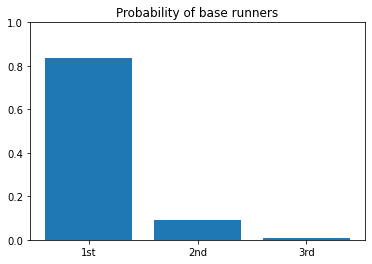

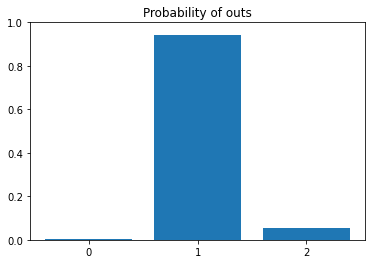

In [152]:
plt.bar(np.arange(3), [pred[5], pred[6], pred[7]])
plt.ylim([0, 1])
plt.xticks(np.arange(3), ['1st', '2nd', '3rd'])
plt.title('Probability of base runners')
plt.show()

plt.bar(np.arange(3), pred[2])
plt.ylim([0, 1])
plt.xticks(np.arange(3), ['0', '1', '2'])
plt.title('Probability of outs')
plt.show()